In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import yfinance as yf


In [14]:


# Define the tickers and download the data
tickers = ['AAPL', 'MSFT', 'GS']
start_date = '2008-12-31'
end_date = '2019-01-31'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculate the daily returns
returns = data.pct_change()

# Calculate the annualized mean return and standard deviation for each stock
mean_returns = returns.mean() * 252
std_devs = returns.std() * 252 ** 0.5

# Calculate the annualized mean return and standard deviation for the portfolio
portfolio_mean_return = mean_returns.mean()
portfolio_std_dev = ((mean_returns ** 2).sum() / 3 + 2 * (mean_returns * std_devs).sum() / 3 + (std_devs ** 2).sum() / 3) ** 0.5

# Calculate the value of the portfolio after one year
portfolio_value = 100 * (1 + portfolio_mean_return)

# Print the results
print(f"Annualized Mean Returns:\n{mean_returns}\n")
print(f"Annualized Standard Deviations:\n{std_devs}\n")
print(f"Portfolio Annualized Mean Return: {portfolio_mean_return:.2%}")
print(f"Portfolio Annualized Standard Deviation: {portfolio_std_dev:.2%}")
print(f"Portfolio Value After One Year: ${portfolio_value:.2f}M")


[*********************100%***********************]  3 of 3 completed
Annualized Mean Returns:
AAPL    0.307743
GS      0.149765
MSFT    0.224466
dtype: float64

Annualized Standard Deviations:
AAPL    0.269237
GS      0.315875
MSFT    0.248527
dtype: float64

Portfolio Annualized Mean Return: 22.73%
Portfolio Annualized Standard Deviation: 50.78%
Portfolio Value After One Year: $122.73M


In [18]:
#1a
# Calculate the log returns of the portfolio
portfolio_log_returns = returns.mean(axis=1).apply(lambda x: np.log(1 + x))

# Multiply the log returns by 100 to get the returns in the -10 to 10 range
portfolio_returns = portfolio_log_returns * 100
portfolio_returns = portfolio_returns.clip(lower=-10, upper=10)
portfolio_returns.dropna(inplace=True)

from arch import arch_model

# Define the model
model_arch = arch_model(portfolio_returns, vol='ARCH', p=1, q=1)

# Fit the model
results_arch = model_arch.fit()

# Print the parameter estimates
print(results_arch.summary())


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11540.512535110847
Iteration:      2,   Func. Count:     12,   Neg. LLF: 4555.889659529816
Iteration:      3,   Func. Count:     19,   Neg. LLF: 4336.064237354028
Iteration:      4,   Func. Count:     25,   Neg. LLF: 4328.899271963412
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4328.328061664913
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4328.328061664913
            Iterations: 5
            Function evaluations: 30
            Gradient evaluations: 5
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4328.33
Distribution:                  Normal   AIC:                           8662.66
Method:            Maximum Likelihood

In [20]:
#1b
# Define the model
model_garch = arch_model(portfolio_returns, vol='GARCH', p=1, q=1)

# Fit the model
results_garch = model_garch.fit()

# Print the parameter estimates
print(results_garch.summary())


Iteration:      1,   Func. Count:      6,   Neg. LLF: 14914.095304172675
Iteration:      2,   Func. Count:     15,   Neg. LLF: 850243283376.1017
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4831.805340878493
Iteration:      4,   Func. Count:     31,   Neg. LLF: 5326.393007364035
Iteration:      5,   Func. Count:     37,   Neg. LLF: 4141.605033828361
Iteration:      6,   Func. Count:     43,   Neg. LLF: 4089.356938321582
Iteration:      7,   Func. Count:     49,   Neg. LLF: 4088.9096495995827
Iteration:      8,   Func. Count:     54,   Neg. LLF: 4088.9073684326645
Iteration:      9,   Func. Count:     59,   Neg. LLF: 4088.907367545564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4088.907367545564
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:             

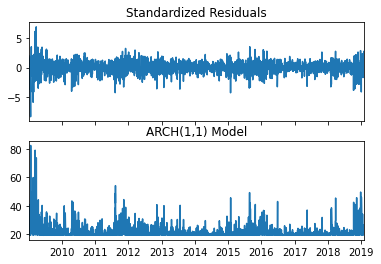

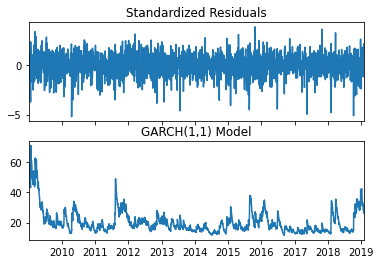

2008-2008 and 2011-2012 has the greatest volatility


In [22]:
#1c
import matplotlib.pyplot as plt

# Plot the conditional variance for the ARCH(1,1) model
fig_arch = results_arch.plot(annualize='D')
plt.title('ARCH(1,1) Model')
plt.show()

# Plot the conditional variance for the GARCH(1,1) model
fig_garch = results_garch.plot(annualize='D')
plt.title('GARCH(1,1) Model')
plt.show()
print('2008-2008 and 2011-2012 has the greatest volatility')

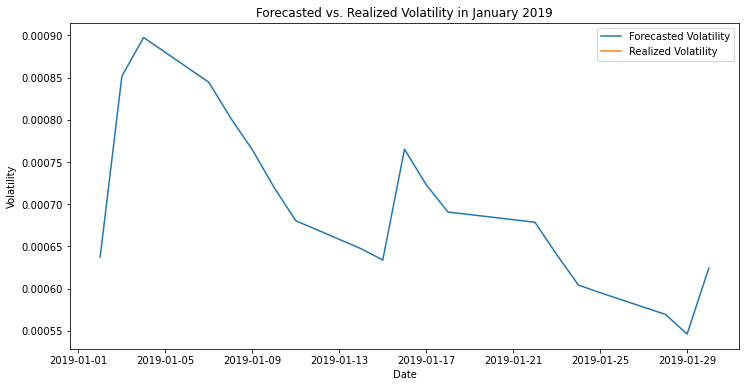

In [28]:
#2 

import pandas as pd

# Define the lambda value for the EWMA model
lam = 0.94

# Calculate the covariance matrix of the log returns
cov_matrix = pd.DataFrame(returns.cov())

# Define the initial value of the volatility
vol_init = cov_matrix.mean().mean()

# Define the EWMA variance function
def ewma_var(data, lam, vol_init):
    vol = vol_init
    ewma_var_list = []
    for i in range(len(data)):
        cov = pd.DataFrame(data.iloc[i] * data.iloc[i].T)
        vol = lam * vol + (1 - lam) * cov.mean().mean()
        ewma_var_list.append(vol)
    return pd.Series(ewma_var_list, index=data.index)

# Calculate the forecasted volatility using the EWMA model
ewma_vol = ewma_var(returns, lam, vol_init)

# Calculate the realized volatility for January 2019
realized_vol = returns.loc['2019-01'].std()

# Plot the forecasted and realized volatility for January 2019
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ewma_vol.loc['2019-01'], label='Forecasted Volatility')
ax.plot(pd.Series(realized_vol, index=ewma_vol.loc['2019-01'].index), label='Realized Volatility')

ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('Forecasted vs. Realized Volatility in January 2019')

ax.legend()
plt.show()
